In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


## Plot Lookup Tables

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.005
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.

INFO:root:aln: Model initialized.


### copy the lookup function of ALN 

In [3]:
def fast_interp2_opt(x, dx, xi, y, dy, yi):

    """
    Returns the values needed for interpolation:
    - bilinear (2D) interpolation within ranges,
    - linear (1D) if "one edge" is crossed,
    - corner value if "two edges" are crossed

    x     ... range of the x value
    xi    ... interpolation value on x-axis
    dx    ... grid width of x ( dx = x[1]-x[0] )
    (same for y)

    return:   xid1    ... index of the lower interpolation value
              dxid    ... distance of xi to the lower interpolation value
              (same for y)
    """

    # within all boundaries
    if xi >= x[0] and xi < x[-1] and yi >= y[0] and yi < y[-1]:
        xid = (xi - x[0]) / dx
        xid1 = np.floor(xid)
        dxid = xid - xid1
        yid = (yi - y[0]) / dy
        yid1 = np.floor(yid)
        dyid = yid - yid1
        return xid1, yid1, dxid, dyid

    # outside one boundary
    if yi < y[0]:
        yid1 = 0
        dyid = 0.0
        if xi >= x[0] and xi < x[-1]:
            xid = (xi - x[0]) / dx
            xid1 = np.floor(xid)
            dxid = xid - xid1

        elif xi < x[0]:
            xid1 = 0
            dxid = 0.0
        else:  # xi >= x(end)
            xid1 = -1
            dxid = 0.0
        return xid1, yid1, dxid, dyid

    if yi >= y[-1]:
        yid1 = -1
        dyid = 0.0
        if xi >= x[0] and xi < x[-1]:
            xid = (xi - x[0]) / dx
            xid1 = np.floor(xid)
            dxid = xid - xid1

        elif xi < x[0]:
            xid1 = 0
            dxid = 0.0

        else:  # xi >= x(end)
            xid1 = -1
            dxid = 0.0
        return xid1, yid1, dxid, dyid

    if xi < x[0]:
        xid1 = 0
        dxid = 0.0
        # We know that yi is within the boundaries
        yid = (yi - y[0]) / dy
        yid1 = np.floor(yid)
        dyid = yid - yid1
        return xid1, yid1, dxid, dyid

    if xi >= x[-1]:
        xid1 = -1
        dxid = 0.0
        # We know that yi is within the boundaries
        yid = (yi - y[0]) / dy
        yid1 = np.floor(yid)
        dyid = yid - yid1

    return xid1, yid1, dxid, dyid


def interpolate_values(table, xid1, yid1, dxid, dyid):
    output = (
        table[yid1, xid1] * (1 - dxid) * (1 - dyid)
        + table[yid1, xid1 + 1] * dxid * (1 - dyid)
        + table[yid1 + 1, xid1] * (1 - dxid) * dyid
        + table[yid1 + 1, xid1 + 1] * dxid * dyid
    )
    return output

In [4]:
precalc_r = aln.params['precalc_r']
precalc_V = aln.params['precalc_V']
precalc_tau_mu = aln.params["precalc_tau_mu"]

C = aln.params["C"]
dI = aln.params["dI"]
ds = aln.params["ds"]
sigmarange = aln.params["sigmarange"]
Irange = aln.params["Irange"]
sigmae_f = 0.

rs = {}
Vs = {}
taus = {}

for mu in np.arange(-1, 4, 0.01):
    xid1, yid1, dxid, dyid = fast_interp2_opt(
        sigmarange, ds, sigmae_f, Irange, dI, mu 
    )
    xid1, yid1 = int(xid1), int(yid1)

    rates_exc = interpolate_values(precalc_r, xid1, yid1, dxid, dyid) * 1e3  # convert kHz to Hz
    Vmean_exc = interpolate_values(precalc_V, xid1, yid1, dxid, dyid)
    tau_exc = interpolate_values(precalc_tau_mu, xid1, yid1, dxid, dyid)
    
    rs[mu] = rates_exc
    Vs[mu] = Vmean_exc
    taus[mu] = tau_exc
    

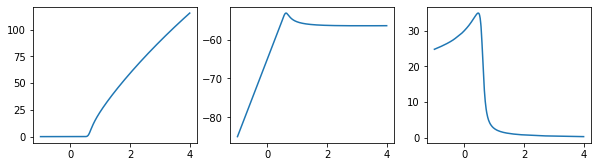

In [5]:
fig, axs = plt.subplots(1,3, figsize=(10,2.5))
axs[0].plot(rs.keys(), rs.values())
axs[1].plot(Vs.keys(), Vs.values())
axs[2].plot(taus.keys(), taus.values())

## now with my style

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

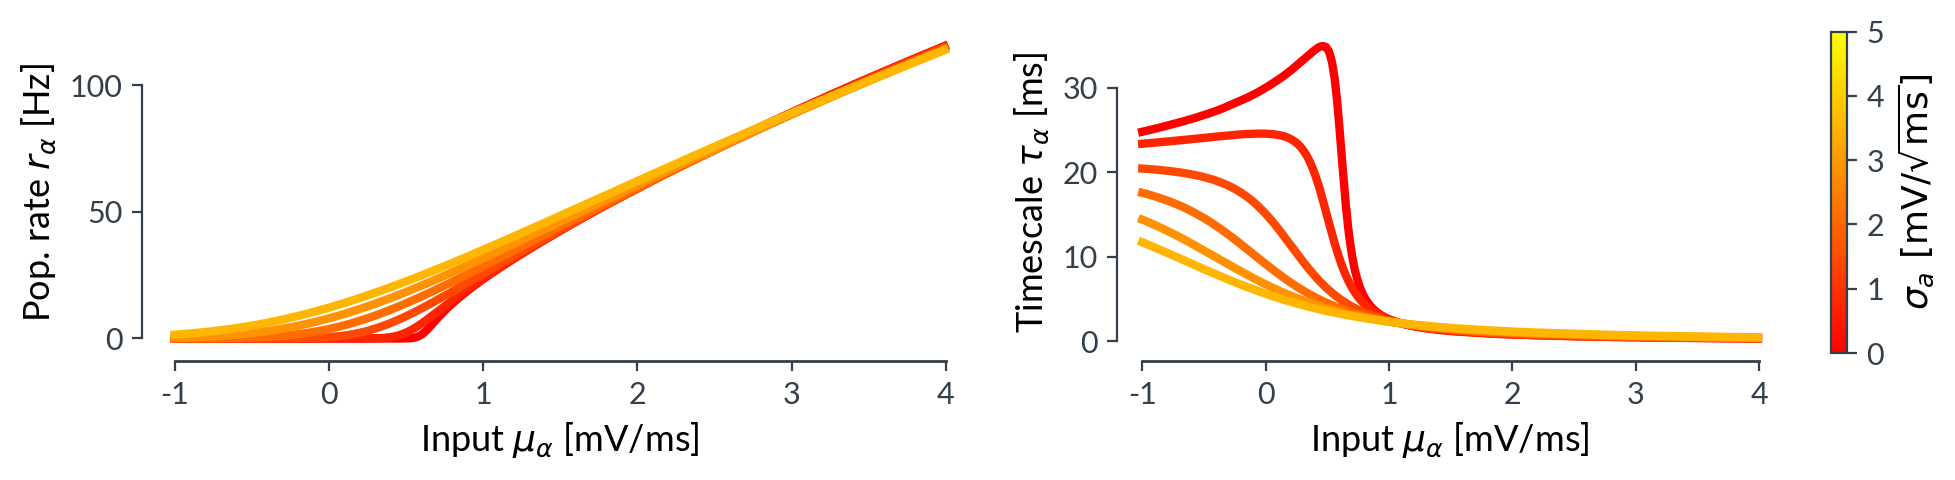

In [7]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1,2, figsize=(10,2.5), dpi=200)

cmap_b = plt.get_cmap('autumn', 8)

for sigma in np.arange(0, 6, 1):
    sigmae_f = sigma

    rs = {}
    Vs = {}
    taus = {}

    for mu in np.arange(-1, 4, 0.01)[::-1]:
        xid1, yid1, dxid, dyid = fast_interp2_opt(
            sigmarange, ds, sigmae_f, Irange, dI, mu 
        )
        xid1, yid1 = int(xid1), int(yid1)

        rates_exc = interpolate_values(precalc_r, xid1, yid1, dxid, dyid) * 1e3  # convert kHz to Hz
        Vmean_exc = interpolate_values(precalc_V, xid1, yid1, dxid, dyid)
        tau_exc = interpolate_values(precalc_tau_mu, xid1, yid1, dxid, dyid)

        rs[mu] = rates_exc
        Vs[mu] = Vmean_exc
        taus[mu] = tau_exc
    
    axs[0].plot(rs.keys(), rs.values(), lw=3, c=cmap_b(sigma))
    #axs[1].plot(Vs.keys(), Vs.values())
    axs[1].plot(taus.keys(), taus.values(), lw=3, c=cmap_b(sigma))

#ax.set_xticks([0, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
#ax.set_xticklabels(labels=['0', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])



axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)


axs[0].set_xticks([-1, 0, 1, 2, 3, 4])
axs[0].set_xticklabels(['-1', '0', '1', '2', '3', '4'])
plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:-1]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", -2))

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_xticklabels(which='both')]
axs[0].spines["bottom"].set_bounds(low=-1, high=4)
axs[0].spines["bottom"].set_linewidth(1)
axs[0].spines["bottom"].set_position(("outward",3))

axs[0].set_xlabel(r"Input $\mu_{\alpha}$ [mV/ms]")
axs[0].set_ylabel(r"Pop. rate $r_{\alpha}$ [Hz]")


axs[1].set_xticks([-1, 0, 1, 2, 3, 4])
axs[1].set_xticklabels(['-1', '0', '1', '2', '3', '4'])
plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][1:-1]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[1].spines["left"].set_position(("outward", -2))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_xticklabels(which='both')]
axs[1].spines["bottom"].set_bounds(low=-1, high=4)
axs[1].spines["bottom"].set_linewidth(1)
axs[1].spines["bottom"].set_position(("outward",3))

axs[1].set_xlabel(r"Input $\mu_{\alpha}$ [mV/ms]")
axs[1].set_ylabel(r"Timescale $\tau_{\alpha}$ [ms]")

normalize = Normalize(vmin=0, vmax=5)
scalarMap = ScalarMappable(norm=normalize, cmap="autumn")

cbar = fig.colorbar(scalarMap)
cbar.ax.set_ylabel(r'$\sigma_a \ \mathrm{[mV/\sqrt{ms}]}$')


fig.tight_layout()
#fig.savefig("Pics/Trfunctions_2.pdf")